### Init

In [16]:
from dotenv import load_dotenv
from lib.seed import seed_prefix 
import sys, os 
load_dotenv()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [17]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
# test_df.to_csv('/home/eiden/eiden/PCOS-roi-classification/v2/data/before_datasheet_test.csv', encoding = 'utf-8-sig', index = False)
test_df.to_csv('/home/eiden/eiden/PCOS-roi-classification/v2/data/datasheet_test.csv', encoding = 'utf-8-sig', index = False)

# # Borderline 제외하는 경우 
# test_df = test_df[test_df['label|0:양성, 1:중간형, 2:악성'] != 1]
# test_df = test_df.reset_index(drop = True)


binary_use = True
num_classes = 1 if binary_use else 3

test_df['label|0:양성, 1:중간형, 2:악성'].value_counts()

label|0:양성, 1:중간형, 2:악성
0    393
1    138
2     61
Name: count, dtype: int64

[Alert] Sample Dataset Use : False
592


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


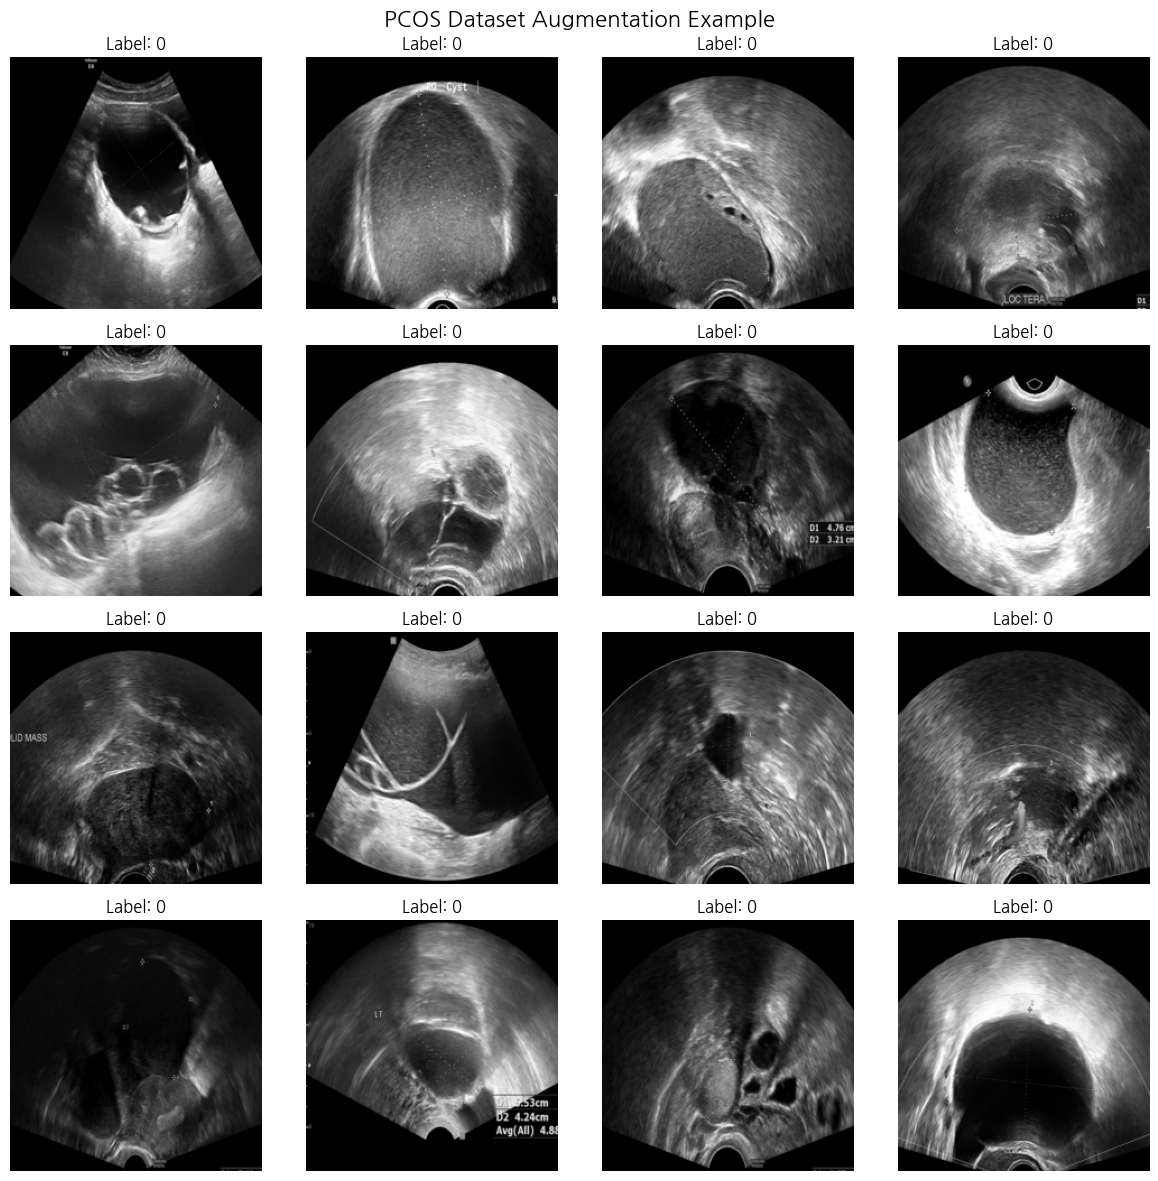

In [18]:
from lib.dataset import PCOS_Dataset
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
test_bs = 24

sample_df = pd.read_csv(os.getenv('SAMPLE_DATASHEET_PATH'))

test_dataset = PCOS_Dataset(
    data_filenames = test_df['filename'],
    data_dir_path  = data_dir,
    labels         = test_df['label|0:양성, 1:중간형, 2:악성'],
    
    # # [Sample Use] for Training
    # sample_data_dir_path= os.getenv('SAMPLE_DATA_PATH'),
    # sample_data_filenames= sample_df['filename'],
    # sample_labels = sample_df['label|0:양성, 1:중간형, 2:악성'],
    
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(225),
        v2.Grayscale(num_output_channels=3),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환 
    ])
)
test_loader = DataLoader(test_dataset, batch_size = test_bs, shuffle = False, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

print(len(test_dataset))
# %% Test Augmentation 
X, y, paths = next(iter(test_loader))
import matplotlib.pyplot as plt
try: 
    fig, axes = plt.subplots(4, 4, figsize = (12, 12))
    fig.suptitle('PCOS Dataset Augmentation Example', fontsize = 16)
    for i in range(16):
        axes[i//4, i%4].imshow(X[i].cpu().permute(1, 2, 0).numpy())
        axes[i//4, i%4].set_title(f'Label: {y[i].item():.0f}')
        axes[i//4, i%4].axis('off')

    plt.tight_layout()
    plt.show()
except:
    pass

# Model Load

In [4]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
save_datetime = "2025-03-28_17-41-27"

#%% ckpt 파일 5개 추출 
from models import get_checkpoint_path
ckpt_paths = get_checkpoint_path(
    checkpoint_dir = './log/',
    datetime = save_datetime
)
#%% json 파일 내에서 model_name, model_version 추출
import simdjson as json
def get_model_series(filepath:str):
    with open(filepath, 'r') as f:
        model_series = json.load(f)
    model_name = model_series['model_name']
    model_version = model_series['model_version']
    return model_name, model_version

model_name, model_version = get_model_series(ckpt_paths[0].replace('.pth', '.json'))

#%% 모델 불러오기
from models import Model_Loader
model = Model_Loader(model_name = model_name + '_' + model_version, num_classes = num_classes).to('cuda')

def get_target_layers(model_name, model):
    if model_name == 'convnext':
        target_layers = [model.features[-1][-1].block] # ConvNext 
    elif model_name == 'resnet':
        target_layers = [model.layer4[-1]] # Resnet18
        
    return target_layers

target_layers = get_target_layers(model_name, model)

#### Optimize, Loss 정의

#### [Settings] Train - Hyper Parmas 정의

In [6]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime

In [7]:

from metric import calculate_metrics, plot_confusion_matrix_from_preds
from lib.pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad
)

from lib.pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from lib.pytorch_grad_cam.utils.image import show_cam_on_image
from visualize import plot_roc_curve, visualize_confidence_scores


# Testing with K-Fold Grad CAM

In [8]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image 
metric_dict = dict()


# 폴드별 예측 확률 저장소 (shape: [fold, N, num_classes or 1])
all_fold_preds = []
# 실제 라벨은 모든 폴드에서 같으므로(동일 테스트셋) 한 번만 저장하면 됨
fixed_test_labels = None

for fold_num, ckpt_path in enumerate(ckpt_paths):
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()
    
    # fold별 CAM 결과 저장 디렉토리
    save_dir = ckpt_path.replace('.pth', '')
    os.makedirs(save_dir, exist_ok=True)
    
    # TP / FP / TN / FN 하위 폴더 미리 생성
    subfolders = ['TP', 'TN', 'FP', 'FN']
    for subf in subfolders:
        os.makedirs(os.path.join(save_dir, subf), exist_ok=True)
    
    
    all_preds = []
    all_labels = []
    
    for X, label, filepaths in tqdm(test_loader, total = len(test_loader), desc = f'Fold_{fold_num+1}'):
        with GradCAM(model = model, target_layers = target_layers) as cam:
            X, label = X.to(device), label.to(device)
            if len(X.shape) == 3: # (C, H, W) -> (B, C, H, W)
                X = X.unsqueeze(0)
            
            cam.batch_size = X.shape[0]
                
            y_res = model(X) # 모델 출력 B x Num Classes
            
            if binary_use:
                y_prob = torch.sigmoid(y_res).detach().cpu()
            else:
                y_prob = F.softmax(y_res, dim = 1).detach().cpu() # 확률 값 : B x Num Classes
            
            all_preds.append(y_prob)
            all_labels.append(label.detach().cpu())

            # ##%% Gray Scale CAM
            # grayscale_cam = cam(
            #     input_tensor = X, 
            #     targets = None,       # targets=None이면 classification score가 가장 높은 클래스에 대한 결과를 보여줌 -> Pred값 보여
            #     # targets = [ClassifierOutputTarget(label)] # 특정 class C에 대한 결과를 확인하려면 아래와 같이 설정
            #     eigen_smooth = True, # Flipping을 통해 실행시간이 x6으로 늘어나서 물체를 잘 보여주도록 함. 
            #     aug_smooth = True, #  # Noise를 제거하여 물체를 잘 보여주도록 함.
            # )
            
            # # 배치를 쪼개서 원본에 CAM 씌움
            # for idx, filepath in enumerate(filepaths):
            #     # (1) CAM mask 만들기
            #     cam_mask = grayscale_cam[idx].cpu().numpy() if torch.is_tensor(grayscale_cam[idx]) else grayscale_cam[idx] # # 만약 grayscale_cam[i]도 torch.Tensor라면 numpy로 변환 (이미 2D여야 함)
            #     # img를 numpy로 변환 & scailing img to 0~1
            #     img = np.asarray(Image.open(filepath).convert('RGB')) / 255.0
            #     # cam_mask size scaling to img size
            #     cam_mask = cv2.resize(cam_mask, (img.shape[1], img.shape[0]))
                
            #     visualization = show_cam_on_image(img, cam_mask, use_rgb=True, image_weight = 0.6)

            #     # (2) 예측 라벨과 실제 라벨 비교
            #     prob_value = y_prob[idx].item() # 확률값 (0~1)
            #     # fold마다 계산된 best threshold 사용
            #     pred_label = 1 if prob_value > 0.964 else 0
            #     true_label = label[idx].item()
            #     # (3) TP, TN, FP, FN 폴더 결정
            #     if pred_label == 1 and true_label == 1: # TP
            #         folder_name = 'TP'
            #     elif pred_label == 0 and true_label == 0: # TN
            #         folder_name = 'TN'
            #     elif pred_label == 1 and true_label == 0: # FP
            #         folder_name = 'FP'
            #     else:                                     # FN
            #         folder_name = 'FN'

            #     # (4) CAM 결과 이미지 저장
            #     dst_path = os.path.join(save_dir, folder_name, os.path.basename(filepath))
            #     cv2.imwrite(dst_path, cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)) # 저장 
            # # 각 파일 처리 후 사용한 메모리 해제
            import gc
            gc.collect()
            
    #%% Test Metric 계산
    test_preds = torch.cat(all_preds, dim = 0)
    test_labels = torch.cat(all_labels, dim = 0)
    
    # Voting용
    all_fold_preds.append(test_preds)  
    fixed_test_labels = test_labels
    # [1] ROC Curve를 통해 최적 Threshold 찾기
    if binary_use:
        # class_names = ['양성', '악성+중간형']
        class_names = ['양성', '악성']
    else: 
        class_names = ['양성', '중간형', '악성']
    
    optimal_threshold = plot_roc_curve(
    true_labels=test_labels,
    pred_probs=test_preds,
    binary_use=binary_use,
    save_path = ckpt_path.replace('.pth' ,'_ROC.png'),
    class_names=class_names,
    )
    print(optimal_threshold)
    
    # Modify the multiclass handling part
    if binary_use:
        optimal_threshold = float(optimal_threshold)
        plot_confusion_matrix_from_preds(
            test_labels, 
            test_preds, 
            binary_use=binary_use, 
            class_names=class_names, 
            save_path=ckpt_path.replace('.pth', '_CM.png'), 
            normalize=True, 
            threshold=optimal_threshold
        )
        # [3] Best Metric 계산
        metric_dict[f'Fold_{fold_num+1}'] = calculate_metrics(
            labels=test_labels, 
            preds=test_preds, 
            binary_use=binary_use, 
            threshold=optimal_threshold
        )
    else:
        # Multiclass-specific modifications
        # Find optimal threshold for each class
        optimal_thresholds = []
        for class_idx in range(test_preds.shape[1]):
            # Extract probabilities for the current class
            class_probs = test_preds[:, class_idx]
            
            # Calculate optimal threshold for this class
            class_optimal_threshold = plot_roc_curve(
                true_labels=(test_labels == class_idx).float(),
                pred_probs=class_probs,
                binary_use=True,
                save_path=ckpt_path.replace('.pth', f'_ROC_Class{class_idx}.png'),
                class_names=[f'Class {class_idx}', f'Not Class {class_idx}']
            )
            optimal_thresholds.append(float(class_optimal_threshold))
        
        # Plot Confusion Matrix with multi-class thresholds
        plot_confusion_matrix_from_preds(
            test_labels, 
            test_preds, 
            binary_use=binary_use, 
            class_names=class_names, 
            save_path=ckpt_path.replace('.pth', '_CM.png'), 
            normalize=True, 
            threshold=optimal_thresholds
        )
        
        # Calculate metrics with multi-class thresholds
        metric_dict[f'Fold_{fold_num+1}'] = calculate_metrics(
            labels=test_labels, 
            preds=test_preds, 
            binary_use=binary_use, 
            threshold=optimal_thresholds
        )
        
        # Add best thresholds to metric dictionary
        metric_dict[f'Fold_{fold_num+1}']['Best Thresholds'] = optimal_thresholds

    # Visualization for multiclass
    visualize_confidence_scores(
        test_preds,
        test_labels,
        class_names=class_names,
        save_path=ckpt_path.replace('.pth', '_Confidence.png')
    )
#     # [2] Confusion Matrix Plot -> 저장
#     if binary_use:
#         optimal_threshold = float(optimal_threshold)
#     else:
#         for i, th in enumerate(optimal_threshold):
#             optimal_threshold[i] = float(th)
                
#         plot_confusion_matrix_from_preds(
#             test_labels, 
#             test_preds, 
#             binary_use=binary_use, 
#             class_names=class_names, 
#             save_path=ckpt_path.replace('.pth', '_CM.png'), 
#             normalize=True, 
#             threshold=optimal_threshold  # Extract the threshold value
#         )
#         # [3] Best Metric 계산
#         metric_dict[f'Fold_{fold_num+1}'] = calculate_metrics(labels = test_labels, preds = test_preds, binary_use = binary_use, threshold = float(optimal_threshold))
#         metric_dict[f'Fold_{fold_num+1}']['Best Threshold'] = float(optimal_threshold)

#         # 폴드별 Confidence Score 시각화
#         visualize_confidence_scores(
#             test_preds,
#             test_labels,
#             class_names=class_names,
#             save_path=ckpt_path.replace('.pth', '_Confidence.png')
#         )


    print(metric_dict[f'Fold_{fold_num+1}'])
    # 폴드 처리 후도 캐시 비우기
    torch.cuda.empty_cache()
    gc.collect()

metric_df = pd.DataFrame(metric_dict).T 
# 통계값 요약 : min, max ,mean 만 보기
# print(metric_df.describe().loc[['min', 'max', 'mean']])
# Metric 저장

Fold_1: 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


{0: np.float32(0.45448843), 1: np.float32(0.33152828), 2: np.float32(0.15284216)}
{'auc': 0.7448272430197806, 'f1': 0.5356216434375977, 'accuracy': 0.6908783783783784, 'recall': 0.5306458896693563, 'auc_per_class': [0.7925249657959006, 0.8271563557428335, 0.6148004075206076], 'f1_per_class': [0.8158567774936062, 0.6055776892430279, 0.18543046357615894], 'recall_per_class': [0.811704834605598, 0.5507246376811594, 0.22950819672131148], 'accuracy_per_class': [np.float64(0.811704834605598), np.float64(0.5507246376811594), np.float64(0.22950819672131148)], 'Best Thresholds': [0.4544884264469147, 0.33152827620506287, 0.15284216403961182]}


Fold_2: 100%|██████████| 25/25 [00:02<00:00,  8.78it/s]


{0: np.float32(0.6306247), 1: np.float32(0.23272634), 2: np.float32(0.25466996)}
{'auc': 0.7395885618907961, 'f1': 0.5670819915976835, 'accuracy': 0.7246621621621622, 'recall': 0.5567564838946231, 'auc_per_class': [0.8119477796105209, 0.8119613100938518, 0.5948565959680159], 'f1_per_class': [0.837037037037037, 0.6160337552742616, 0.24817518248175183], 'recall_per_class': [0.8625954198473282, 0.5289855072463768, 0.2786885245901639], 'accuracy_per_class': [np.float64(0.8625954198473282), np.float64(0.5289855072463768), np.float64(0.2786885245901639)], 'Best Thresholds': [0.6306247115135193, 0.2327263355255127, 0.2546699643135071]}


Fold_3: 100%|██████████| 25/25 [00:02<00:00,  8.50it/s]


{0: np.float32(0.54957014), 1: np.float32(0.121627346), 2: np.float32(0.02806464)}
{'auc': 0.7343193618138679, 'f1': 0.5050395286744105, 'accuracy': 0.6908783783783784, 'recall': 0.4918059991403372, 'auc_per_class': [0.7897502781080976, 0.8203888144033711, 0.5928189929301348], 'f1_per_class': [0.8215158924205379, 0.5454545454545454, 0.14814814814814814], 'recall_per_class': [0.8549618320610687, 0.45652173913043476, 0.16393442622950818], 'accuracy_per_class': [np.float64(0.8549618320610687), np.float64(0.45652173913043476), np.float64(0.16393442622950818)], 'Best Thresholds': [0.5495701432228088, 0.12162734568119049, 0.02806464023888111]}


Fold_4: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


{0: np.float32(0.29601917), 1: np.float32(0.342065), 2: np.float32(0.097145)}
{'auc': 0.735942798789683, 'f1': 0.5324443349266975, 'accuracy': 0.6908783783783784, 'recall': 0.5261151283116211, 'auc_per_class': [0.7916043320930352, 0.8492147098257038, 0.5670093544503102], 'f1_per_class': [0.8050632911392405, 0.6196078431372549, 0.17266187050359713], 'recall_per_class': [0.8091603053435115, 0.572463768115942, 0.19672131147540983], 'accuracy_per_class': [np.float64(0.8091603053435115), np.float64(0.572463768115942), np.float64(0.19672131147540983)], 'Best Thresholds': [0.29601916670799255, 0.3420650064945221, 0.09714499861001968]}


Fold_5: 100%|██████████| 25/25 [00:03<00:00,  7.98it/s]


{0: np.float32(0.7770255), 1: np.float32(0.22377183), 2: np.float32(0.05338874)}
{'auc': 0.7409857426356394, 'f1': 0.5322381822549767, 'accuracy': 0.6993243243243243, 'recall': 0.5207812291243107, 'auc_per_class': [0.7894306136279361, 0.8266296367234884, 0.6068969775554939], 'f1_per_class': [0.8151774785801713, 0.5677966101694916, 0.21374045801526717], 'recall_per_class': [0.8473282442748091, 0.4855072463768116, 0.22950819672131148], 'accuracy_per_class': [np.float64(0.8473282442748091), np.float64(0.4855072463768116), np.float64(0.22950819672131148)], 'Best Thresholds': [0.7770255208015442, 0.2237718254327774, 0.05338874086737633]}


In [9]:
# Soft Voting 최종 결과 계산
ensemble_preds = torch.mean(torch.stack(all_fold_preds, dim=0), dim=0)  # 모든 폴드의 예측 평균
print(ensemble_preds.shape, fixed_test_labels.shape)

print("\n===== Soft-Voting 최종 결과 =====")

# 최적 임계값 및 성능 지표 계산 (바이너리와 멀티클래스 모두 지원)
if binary_use:
    # 바이너리 분류의 경우
    roc_result = plot_roc_curve(
        true_labels=fixed_test_labels,
        pred_probs=ensemble_preds,
        binary_use=True,
        save_path=ckpt_path.replace('fold5.pth', 'AVG_ROC.png'),
        class_names=class_names
    )
    
    # roc_result에서 최적 임계값 추출 (딕셔너리인 경우)
    SoftVoting_opt_threshold = roc_result.get('optimal_threshold', 0.5)
    
    plot_confusion_matrix_from_preds(
        fixed_test_labels, 
        ensemble_preds,
        binary_use=True,
        class_names=class_names,
        save_path=ckpt_path.replace('fold5.pth', 'AVG_CM.png'),
        normalize=True,
        threshold=float(SoftVoting_opt_threshold)
    )
else:
    # 멀티클래스 분류의 경우
    roc_result = plot_roc_curve(
        true_labels=fixed_test_labels,
        pred_probs=ensemble_preds,
        binary_use=False,
        save_path=ckpt_path.replace('fold5.pth', 'AVG_ROC.png'),
        class_names=class_names
    )
    
    # 멀티클래스의 경우 임계값 처리 방식 변경
    SoftVoting_opt_threshold = 0.5  # 기본 임계값
    
    plot_confusion_matrix_from_preds(
        fixed_test_labels, 
        ensemble_preds,
        binary_use=False,
        class_names=class_names,
        save_path=ckpt_path.replace('fold5.pth', 'AVG_CM.png'),
        normalize=True
    )

# 신뢰도 점수 시각화 (바이너리/멀티클래스 모두 지원)
visualize_confidence_scores(
    ensemble_preds,
    fixed_test_labels,
    class_names=class_names,
    save_path=ckpt_path.replace('fold5.pth', 'AVG_Confidence.png')
)

# 메트릭 계산 (바이너리/멀티클래스 모두 지원)
if binary_use:
    SoftVoting_metric = calculate_metrics(
        labels=fixed_test_labels, 
        preds=ensemble_preds,
        binary_use=True,
        threshold=float(SoftVoting_opt_threshold)
    )
else:
    SoftVoting_metric = calculate_metrics(
        labels=fixed_test_labels, 
        preds=ensemble_preds,
        binary_use=False
    )

# 최적 임계값 추가 (기존 문제 해결)
if isinstance(SoftVoting_opt_threshold, dict):
    SoftVoting_metric['Best Threshold'] = float(SoftVoting_opt_threshold.get('optimal_threshold', 0.5))
else:
    SoftVoting_metric['Best Threshold'] = float(SoftVoting_opt_threshold)

# 메트릭 데이터프레임에 통합
all_metric_df = metric_df.copy()
all_metric_df.loc['SoftVoting'] = SoftVoting_metric
all_metric_df = all_metric_df.round(3)

# CSV로 저장
all_metric_df.to_csv(ckpt_path.replace('fold5.pth', 'metric.csv'), encoding='utf-8-sig')

# 결과 출력
all_metric_df

torch.Size([592, 3]) torch.Size([592])

===== Soft-Voting 최종 결과 =====


,auc,f1,accuracy,recall,auc_per_class,f1_per_class,recall_per_class,accuracy_per_class,Best Thresholds
Fold_1,0.744827,0.535622,0.690878,0.530646,"[0.7925249657959006, 0.8271563557428335, 0.614...","[0.8158567774936062, 0.6055776892430279, 0.185...","[0.811704834605598, 0.5507246376811594, 0.2295...","[0.811704834605598, 0.5507246376811594, 0.2295...","[0.4544884264469147, 0.33152827620506287, 0.15..."
Fold_2,0.739589,0.567082,0.724662,0.556756,"[0.8119477796105209, 0.8119613100938518, 0.594...","[0.837037037037037, 0.6160337552742616, 0.2481...","[0.8625954198473282, 0.5289855072463768, 0.278...","[0.8625954198473282, 0.5289855072463768, 0.278...","[0.6306247115135193, 0.2327263355255127, 0.254..."
Fold_3,0.734319,0.50504,0.690878,0.491806,"[0.7897502781080976, 0.8203888144033711, 0.592...","[0.8215158924205379, 0.5454545454545454, 0.148...","[0.8549618320610687, 0.45652173913043476, 0.16...","[0.8549618320610687, 0.45652173913043476, 0.16...","[0.5495701432228088, 0.12162734568119049, 0.02..."
Fold_4,0.735943,0.532444,0.690878,0.526115,"[0.7916043320930352, 0.8492147098257038, 0.567...","[0.8050632911392405, 0.6196078431372549, 0.172...","[0.8091603053435115, 0.572463768115942, 0.1967...","[0.8091603053435115, 0.572463768115942, 0.1967...","[0.29601916670799255, 0.3420650064945221, 0.09..."
Fold_5,0.740986,0.532238,0.699324,0.520781,"[0.7894306136279361, 0.8266296367234884, 0.606...","[0.8151774785801713, 0.5677966101694916, 0.213...","[0.8473282442748091, 0.4855072463768116, 0.229...","[0.8473282442748091, 0.4855072463768116, 0.229...","[0.7770255208015442, 0.2237718254327774, 0.053..."
SoftVoting,0.751088,0.545273,0.716216,0.53405,"[0.8068203613487284, 0.8434686841601227, 0.602...","[0.8325123152709359, 0.6033057851239669, 0.2]","[0.8600508905852418, 0.5289855072463768, 0.213...","[0.8600508905852418, 0.5289855072463768, 0.213...",NaN


In [10]:
def binary_use_option(labels, borderline_to_class: str):
    """
    before_datasheet.csv (0 - 양성, 1 - 중간형, 2 - 악성)
    datasheet.csv         (0 - 양성, 1 - 악성, 2 - 중간형)

    borderline_to_class 에 따라:
    - "benign"          => label=2 를 1로, 나머지 0
    - "malignant"       => label=0 을 0으로, 나머지 1
    - "borderline to 1" => label=1 을 1로, 나머지 0
    """
    # 먼저 복사해서 경고 방지
    labels = labels.copy()

    if True:
        if borderline_to_class == "benign":
            # label=2 => 1, 그 외 => 0
            labels = (labels == 2).astype(int)
        elif borderline_to_class == "malignant":
            # label=0 => 0, 그 외 => 1
            labels = (labels != 0).astype(int)
        elif borderline_to_class == "borderline to 1":
            # label=1 => 1, 그 외 => 0
            labels = (labels == 1).astype(int)

    return labels

In [11]:
labels = pd.Series([0, 1, 2])

for label in labels:
    label = 1 if label == 0 else 0 # 반대로 지정해보기 1 : 양성 / 0 : 악성 및 보더라인
    print(label)
    

1
0
0


In [12]:
first_dict = {'abc' : 1}
second_dict = {'def' : 2}
# {'def' : 2} 결합
combined_dict = {**first_dict, **second_dict}
combined_dict

{'abc': 1, 'def': 2}